# Realizable PID Control

## 1.PID Control with Significant Measurement Noise

PID control that implements setpoint weighting and anti-reset windup.

In [3]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma = 0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control 
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, PV, SP = data
        else:
            t,PV,SP,TR = data
            I = TR - MV_bar - P - D
            
        # PID calculations 
        P = Kp*(beta*SP-PV)
        I = I + Ki*(SP-PV)*(t-t_prev)
        eD = gamma*SP-PV
        D = Kd*(eD-eD_prev)/(t-t_prev)
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        I = MV - MV_bar - P - D
        
        # Update stored data for next iteration
        eD_prev = eD
        t_prev = t

where the measurement error is a normal random variable with zero mean and a standard deviation of 2 
degree C.For this example we've deliberately chosen a large value of Kd = 10 to illustrate the issue of using
significant amounts of derivative control in presence of measurement noise.

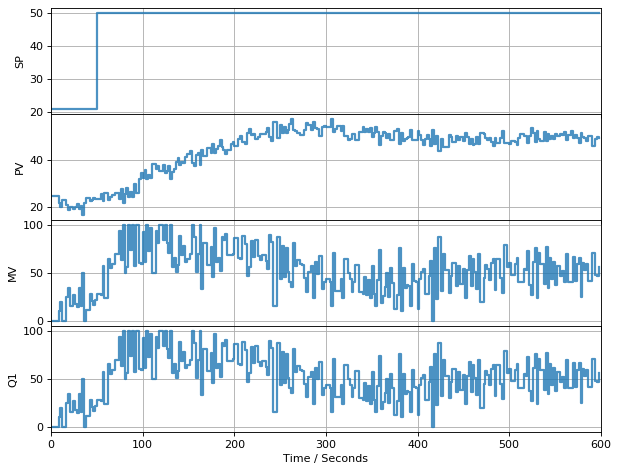

TCLab Model disconnected successfully.


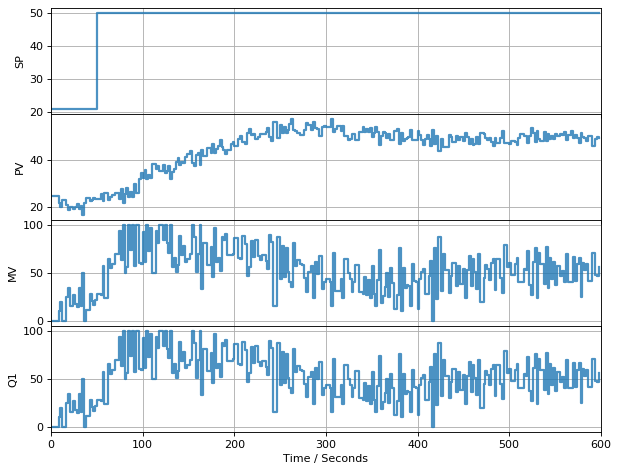

In [5]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter
import numpy as np

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 10, beta=0) # create pid control
controller.send(None) # initialize

tfinal = 600

with TCLab() as lab:
    h = Historian([('SP', lambda:SP),('PV', lambda:PV), ('MV', lambda:MV),('Q1',lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50 # get setpoint
        PV = lab.T1 + 2*np.random.normal() # get measurement
        MV = controller.send([t,PV,SP,lab.Q1()]) # compute manipulated variable
        lab.Q1(MV) # apply
        p.update(t) # update information display

## 2.PID Control modifying the Derivative Term

To show the impact of this change in the implementation of the derivative term, 
we repeat the experiment above with the revised algorithm and  N=1 . 
(A more typical value of  N  is 5 or 10, but we've chosen a somewhat more conservative value 
because of the magnitude of the measurement noise present in this example, 
and the large value of  Kd  chosen to demonstrate the issues.

In [ ]:
#define PID revisited
def PID(Kp, Ki, Kd, MV_bar=0, MV_min=0, MV_max=100, beta=1, gamma=0, N=10):
    
    # initial yield and return
    data = yield MV_bar
    t = data[0:3]
    
    P = Kp*(beta*SP-PV)
    MV = MV_bar + P
    MV = 0 if MV < 0 else 100 if MV > 100 else MV
    I = 0 
    D = 0 
    dU = 0
    
    S = Kd*(gamma*SP-PV)
    t_prev = t